In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -q torch torchvision torchaudio einops scikit-learn pandas numpy


In [ ]:
# ================= CONFIG =================
CT_ROOT = "/content/drive/MyDrive/CT_HU_Windowed"
LABELS_PATH = "/content/drive/MyDrive/labels.csv"

# CPU-safe input size
INPUT_SHAPE = (48, 96, 96)   # (Depth, Height, Width)

BATCH_SIZE = 1
EPOCHS = 5                  # pipeline verification
LEARNING_RATE = 1e-4
NUM_WORKERS = 0              # MUST be 0 on CPU
DEVICE = "cpu"
# =========================================


In [ ]:
# Check CT folders
patients = sorted(os.listdir(CT_ROOT))
print("Patients found:", len(patients))
print("First 5 patients:", patients[:5])

# Check one patient
sample = patients[0]
series_path = f"{CT_ROOT}/{sample}/series_1"
print("Slices in series_1:", len(os.listdir(series_path)))


Patients found: 100
First 5 patients: ['LIDC-IDRI-0001', 'LIDC-IDRI-0002', 'LIDC-IDRI-0003', 'LIDC-IDRI-0004', 'LIDC-IDRI-0005']
Slices in series_1: 133


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import os

class LIDCDataset(Dataset):
    def __init__(self, ct_root, labels_csv, input_shape):
        self.ct_root = ct_root
        self.input_shape = input_shape

        df = pd.read_csv(labels_csv)
        self.samples = df[["patient_id", "label"]].values

    def __len__(self):
        return len(self.samples)

    def load_volume(self, patient_id):
        series_path = os.path.join(self.ct_root, patient_id, "series_1")
        slice_files = sorted(os.listdir(series_path))

        volume = np.stack([
            np.load(os.path.join(series_path, s))
            for s in slice_files
        ])  # (D, H, W)

        # --- Depth resampling ---
        target_d, target_h, target_w = self.input_shape
        idx = np.linspace(0, volume.shape[0] - 1, target_d).astype(int)
        volume = volume[idx]

        # --- Resize H & W ---
        volume = torch.tensor(volume).unsqueeze(0).unsqueeze(0)
        volume = F.interpolate(
            volume,
            size=(target_d, target_h, target_w),
            mode="trilinear",
            align_corners=False
        )
        volume = volume.squeeze().numpy()

        # --- Normalize ---
        volume = (volume - volume.mean()) / (volume.std() + 1e-6)

        return volume.astype(np.float32)

    def __getitem__(self, idx):
        patient_id, label = self.samples[idx]
        volume = self.load_volume(patient_id)

        return (
            torch.tensor(volume).unsqueeze(0),  # (1, D, H, W)
            torch.tensor(label).long()
        )


In [ ]:
dataset = LIDCDataset(CT_ROOT, LABELS_PATH, INPUT_SHAPE)

x, y = dataset[0]
print("Volume shape:", x.shape)
print("Label:", y)


Volume shape: torch.Size([1, 48, 96, 96])
Label: tensor(1)


In [ ]:
import torch.nn as nn
from einops import rearrange

class CNNTransformer3D_CPU(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv3d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv3d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv3d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=64,
                nhead=4,
                dim_feedforward=256,
                batch_first=True
            ),
            num_layers=2
        )

        self.classifier = nn.Linear(64, 2)

    def forward(self, x):
        x = self.cnn(x)                       # (B, C, D, H, W)
        x = rearrange(x, "b c d h w -> b (d h w) c")
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)


In [ ]:
from torch.utils.data import DataLoader

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)


In [ ]:
pip install -q tqdm


In [ ]:
from tqdm import tqdm


In [ ]:
import torch

model = CNNTransformer3D_CPU().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    # Progress bar for batches
    progress_bar = tqdm(
        loader,
        desc=f"Epoch {epoch+1}/{EPOCHS}",
        leave=True
    )

    for x, y in progress_bar:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        epoch_loss += batch_loss

        # Update progress bar
        progress_bar.set_postfix({
            "batch_loss": f"{batch_loss:.4f}"
        })

    avg_loss = epoch_loss / len(loader)
    print(f"\n✅ Epoch {epoch+1} completed | Avg Loss: {avg_loss:.4f}\n")


Epoch 1/5: 100%|██████████| 100/100 [17:34<00:00, 10.54s/it, batch_loss=0.2901]



✅ Epoch 1 completed | Avg Loss: 0.6593



Epoch 2/5: 100%|██████████| 100/100 [14:26<00:00,  8.66s/it, batch_loss=0.2933]



✅ Epoch 2 completed | Avg Loss: 0.6611



Epoch 3/5: 100%|██████████| 100/100 [14:42<00:00,  8.82s/it, batch_loss=0.9078]



✅ Epoch 3 completed | Avg Loss: 0.6227



Epoch 4/5: 100%|██████████| 100/100 [15:17<00:00,  9.18s/it, batch_loss=1.3391]



✅ Epoch 4 completed | Avg Loss: 0.6380



Epoch 5/5: 100%|██████████| 100/100 [16:28<00:00,  9.88s/it, batch_loss=0.2553]


✅ Epoch 5 completed | Avg Loss: 0.6240



In [ ]:
import torch
import os

SAVE_PATH = "/content/drive/MyDrive/cnn_transformer_cpu.pth"

# Make sure directory exists
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

# Save model weights
torch.save(model.state_dict(), SAVE_PATH)

print("✅ Model successfully saved at:")
print(SAVE_PATH)


✅ Model successfully saved at:
/content/drive/MyDrive/cnn_transformer_cpu.pth


In [ ]:
print("File exists:", os.path.exists(SAVE_PATH))

# Test loading
test_model = CNNTransformer3D_CPU()
test_model.load_state_dict(torch.load(SAVE_PATH, map_location="cpu"))
test_model.eval()

print("✅ Model reload successful")


File exists: True
✅ Model reload successful


In [ ]:
# Core
import os
import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Metrics
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    classification_report
)

# Utils
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
CT_ROOT = "/content/drive/MyDrive/CT_HU_Windowed"
LABELS_PATH = "/content/drive/MyDrive/labels.csv"

INPUT_SHAPE = (48, 96, 96)   # must match training
BATCH_SIZE = 1
DEVICE = "cpu"
NUM_WORKERS = 0


In [ ]:
from sklearn.model_selection import train_test_split

labels_df = pd.read_csv(LABELS_PATH)

train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df["label"],
    random_state=42
)

print("Train patients:", len(train_df))
print("Validation patients:", len(val_df))
print(val_df["label"].value_counts())


Train patients: 80
Validation patients: 20
label
1    14
0     6
Name: count, dtype: int64


In [ ]:
class LIDCDataset(Dataset):
    def __init__(self, ct_root, dataframe, input_shape):
        self.ct_root = ct_root
        self.input_shape = input_shape
        self.samples = dataframe[["patient_id", "label"]].values

    def __len__(self):
        return len(self.samples)

    def load_volume(self, patient_id):
        series_path = os.path.join(self.ct_root, patient_id, "series_1")
        slice_files = sorted(os.listdir(series_path))

        volume = np.stack([
            np.load(os.path.join(series_path, s))
            for s in slice_files
        ])  # (D, H, W)

        # Depth resample
        target_d, target_h, target_w = self.input_shape
        idx = np.linspace(0, volume.shape[0] - 1, target_d).astype(int)
        volume = volume[idx]

        # Resize
        volume = torch.tensor(volume).unsqueeze(0).unsqueeze(0)
        volume = F.interpolate(
            volume,
            size=(target_d, target_h, target_w),
            mode="trilinear",
            align_corners=False
        )
        volume = volume.squeeze().numpy()

        # Normalize
        volume = (volume - volume.mean()) / (volume.std() + 1e-6)
        return volume.astype(np.float32)

    def __getitem__(self, idx):
        patient_id, label = self.samples[idx]
        volume = self.load_volume(patient_id)
        return torch.tensor(volume).unsqueeze(0), torch.tensor(label).long()


In [ ]:
val_dataset = LIDCDataset(CT_ROOT, val_df, INPUT_SHAPE)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS
)


In [ ]:
from einops import rearrange

class CNNTransformer3D_CPU(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv3d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=64,
                nhead=4,
                dim_feedforward=256,
                batch_first=True
            ),
            num_layers=2
        )

        self.classifier = nn.Linear(64, 2)

    def forward(self, x):
        x = self.cnn(x)
        x = rearrange(x, "b c d h w -> b (d h w) c")
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)


In [ ]:
model = CNNTransformer3D_CPU().to(DEVICE)

CHECKPOINT_PATH = "/content/drive/MyDrive/cnn_transformer_cpu.pth"
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))

model.eval()
print("✅ Model loaded and set to eval mode")


✅ Model loaded and set to eval mode


In [ ]:
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Validating"):
        x = x.to(DEVICE)

        logits = model(x)
        probs = torch.softmax(logits, dim=1)[:, 1]

        all_probs.append(probs.item())
        all_labels.append(y.item())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)


Validating: 100%|██████████| 20/20 [02:58<00:00,  8.94s/it]


In [ ]:
auc = roc_auc_score(all_labels, all_probs)
preds = (all_probs >= 0.5).astype(int)

acc = accuracy_score(all_labels, preds)
tn, fp, fn, tp = confusion_matrix(all_labels, preds).ravel()

sensitivity = tp / (tp + fn + 1e-6)
specificity = tn / (tn + fp + 1e-6)

print("===== VALIDATION METRICS =====")
print(f"AUC-ROC     : {auc:.3f}")
print(f"Accuracy    : {acc:.3f}")
print(f"Sensitivity : {sensitivity:.3f}")
print(f"Specificity : {specificity:.3f}")


===== VALIDATION METRICS =====
AUC-ROC     : 0.667
Accuracy    : 0.700
Sensitivity : 1.000
Specificity : 0.000


In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, preds, target_names=["No Cancer", "Cancer"]))



Classification Report:
              precision    recall  f1-score   support

   No Cancer       0.00      0.00      0.00         6
      Cancer       0.70      1.00      0.82        14

    accuracy                           0.70        20
   macro avg       0.35      0.50      0.41        20
weighted avg       0.49      0.70      0.58        20



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


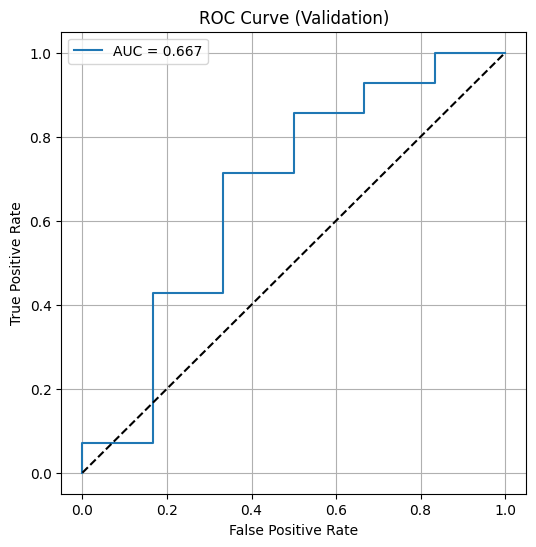

In [ ]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
val_results = val_df.copy()
val_results["prob_cancer"] = all_probs
val_results["pred_label"] = preds

SAVE_VAL_PATH = "/content/drive/MyDrive/validation_results.csv"
val_results.to_csv(SAVE_VAL_PATH, index=False)

print("✅ Validation predictions saved at:", SAVE_VAL_PATH)


✅ Validation predictions saved at: /content/drive/MyDrive/validation_results.csv
